### This example demonstrates XCSF (single-step) reinforcement learning applied to the real-multiplexer problem. Classifiers are composed of hyperrectangle conditions, linear least squares predictions, and integer actions.

In [1]:
from __future__ import annotations

import json
import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import xcsf

RANDOM_STATE: int = 1
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Create a real-multiplexer problem class

In [2]:
class Mux:
    """
    Real-multiplexer problem environment.

    The Mux class generates random real vectors of length k+pow(2,k) where the
    first k bits determine the position of the output bit in the last pow(2,k)
    bits. E.g., for a 3-bit problem, the first (rounded) bit addresses which of
    the following 2 bits are the (rounded) output.

    Example valid lengths: 3, 6, 11, 20, 37, 70, 135, 264.
    """

    def __init__(self, binary: bool, n_bits: int, payoff_map: bool) -> None:
        """Constructs a new real-multiplexer problem of maximum size n_bits."""
        self.binary: bool = binary  #: whether binary or real mux
        self.n_bits: int = n_bits  #: total number of bits
        self.n_actions: int = 2  #: total number of actions
        self.state: np.ndarray = np.zeros(n_bits)  #: current mux state
        self.pos_bits: int = 1  #: number of addressing bits
        while self.pos_bits + pow(2, self.pos_bits) <= self.n_bits:
            self.pos_bits += 1
        self.pos_bits -= 1
        self.payoff_map: bool = payoff_map  #: whether to use a payoff map
        self.max_payoff: float = 1  #: reward for a correct prediction
        if payoff_map:
            self.max_payoff = 0.2 + 0.2 * pow(2, self.pos_bits)
        if self.binary:
            print("Binary multiplexer:")
        else:
            print("Real multiplexer:")
        print(f"{self.n_bits} bits, {self.pos_bits} position bits")

    def reset(self) -> None:
        """Generates a random real-multiplexer state."""
        for i in range(self.n_bits):
            self.state[i] = random.random()
        if self.binary:
            self.state = np.rint(self.state)

    def answer_pos(self) -> int:
        """Returns the position of the bit addressed by the current mux state."""
        pos: int = self.pos_bits
        for i in range(self.pos_bits):
            if self.answer(i) == 1:
                pos += pow(2, self.pos_bits - 1 - i)
        return pos

    def answer(self, pos: int) -> int:
        """Returns the (discretised) bit at a given position in the mux state."""
        if self.state[pos] > 0.5:
            return 1
        return 0

    def execute(self, act: int) -> tuple[bool, float]:
        """Returns the reward for performing an action."""
        correct: bool = False
        reward: float = 0
        pos: int = self.answer_pos()
        answer: int = self.answer(pos)
        if act == answer:
            correct = True
            if self.payoff_map:
                reward = 0.3 + (pos - self.pos_bits) * 0.2
                if answer == 1:
                    reward += 0.1
            else:
                reward = self.max_payoff
        elif self.payoff_map:
            reward = (pos - self.pos_bits) * 0.2
            if answer == 1:
                reward += 0.1
        else:
            reward = 0
        return correct, reward

### Instantiate a new real-multiplexer problem

In [3]:
mux: Mux = Mux(binary=False, n_bits=11, payoff_map=False)
X_DIM: int = mux.n_bits
N_ACTIONS: int = mux.n_actions
MAX_PAYOFF: float = mux.max_payoff

Real multiplexer:
11 bits, 3 position bits


### Initialise XCSF

In [4]:
xcs: xcsf.XCS = xcsf.XCS(
    x_dim=X_DIM,
    y_dim=1,
    n_actions=N_ACTIONS,
    alpha=0.1,
    beta=0.2,
    delta=0.1,
    e0=0.01,
    init_error=0,
    init_fitness=0.01,
    m_probation=10000,
    nu=5,
    omp_num_threads=12,
    perf_trials=1000,
    pop_init=False,
    pop_size=5000,
    random_state=RANDOM_STATE,
    set_subsumption=True,
    theta_del=20,
    theta_sub=100,
    ea={
        "select_type": "tournament",
        "select_size": 0.4,
        "theta_ea": 25,
        "lambda": 2,
        "p_crossover": 0.8,
        "err_reduc": 0.25,
        "fit_reduc": 0.1,
        "subsumption": True,
        "pred_reset": False,
    },
    action={
        "type": "integer",
    },
    condition={
        "type": "hyperrectangle_ubr",
        "args": {
            "min": 0.0,
            "max": 1.0,
            "spread_min": 1.0,
        },
    },
    prediction={
        "type": "nlms_linear",
        "args": {
            "eta": 1.0,
            "eta_min": 0.0001,
            "evolve_eta": True,
        },
    },
)

print(json.dumps(xcs.internal_params(), indent=4))

{
    "version": "1.3.0",
    "x_dim": 11,
    "y_dim": 1,
    "n_actions": 2,
    "omp_num_threads": 12,
    "random_state": 1,
    "population_file": "",
    "pop_init": false,
    "max_trials": 100000,
    "perf_trials": 1000,
    "pop_size": 5000,
    "loss_func": "mae",
    "gamma": 0.95,
    "teletransportation": 50,
    "p_explore": 0.9,
    "set_subsumption": true,
    "theta_sub": 100,
    "e0": 0.01,
    "alpha": 0.1,
    "nu": 5,
    "beta": 0.2,
    "delta": 0.1,
    "theta_del": 20,
    "init_fitness": 0.01,
    "init_error": 0,
    "m_probation": 10000,
    "stateful": true,
    "compaction": false,
    "ea": {
        "select_type": "tournament",
        "select_size": 0.4,
        "theta_ea": 25,
        "lambda": 2,
        "p_crossover": 0.8,
        "err_reduc": 0.25,
        "fit_reduc": 0.1,
        "subsumption": true,
        "pred_reset": false
    },
    "action": {
        "type": "integer"
    },
    "condition": {
        "type": "hyperrectangle_ubr",
      

### Execute experiment

In [5]:
PERF_TRIALS: int = 1000  # number of trials over which to average performance
N: int = 100  # 100,000 trials in total to run
trials: np.ndarray = np.zeros(N)
psize: np.ndarray = np.zeros(N)
msize: np.ndarray = np.zeros(N)
performance: np.ndarray = np.zeros(N)
error: np.ndarray = np.zeros(N)


def egreedy_action(state: np.ndarray, epsilon: float) -> tuple[int, float]:
    """Selects an action using an epsilon greedy policy."""
    if np.random.rand() < epsilon:
        return random.randrange(N_ACTIONS), 0
    prediction_array = xcs.predict(state.reshape(1, -1))[0]
    # break ties randomly
    best_actions = np.where(prediction_array == prediction_array.max())[0]
    action = int(np.random.choice(best_actions))
    prediction = prediction_array[action]
    return action, prediction


def run_experiment() -> None:
    """Executes a single experiment."""
    bar = tqdm(total=N)  # progress bar
    for i in range(N):
        for _ in range(PERF_TRIALS):
            # explore trial
            mux.reset()
            action, prediction = egreedy_action(mux.state, 1)  # random action
            _, reward = mux.execute(action)
            xcs.fit(mux.state, action, reward)  # update action set, run EA, etc.
            # exploit trial
            mux.reset()
            action, prediction = egreedy_action(mux.state, 0)  # best action
            correct, reward = mux.execute(action)
            performance[i] += 1 if correct else 0
            error[i] += abs(reward - prediction) / MAX_PAYOFF
        performance[i] /= float(PERF_TRIALS)
        error[i] /= PERF_TRIALS
        trials[i] = xcs.time()  # number of learning updates performed
        psize[i] = xcs.pset_size()  # current population size
        msize[i] = xcs.mset_size()  # avg match set size
        status = (  # update status
            f"trials={trials[i]:.0f} "
            f"performance={performance[i]:.5f} "
            f"error={error[i]:.5f} "
            f"psize={psize[i]:.1f} "
            f"msize={msize[i]:.1f}"
        )
        bar.set_description(status)
        bar.refresh()
        bar.update(1)
    bar.close()


run_experiment()

trials=100000 performance=0.99200 error=0.01708 psize=5000.0 msize=182.4: 100%|██████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20it/s]


### Plot XCSF learning performance

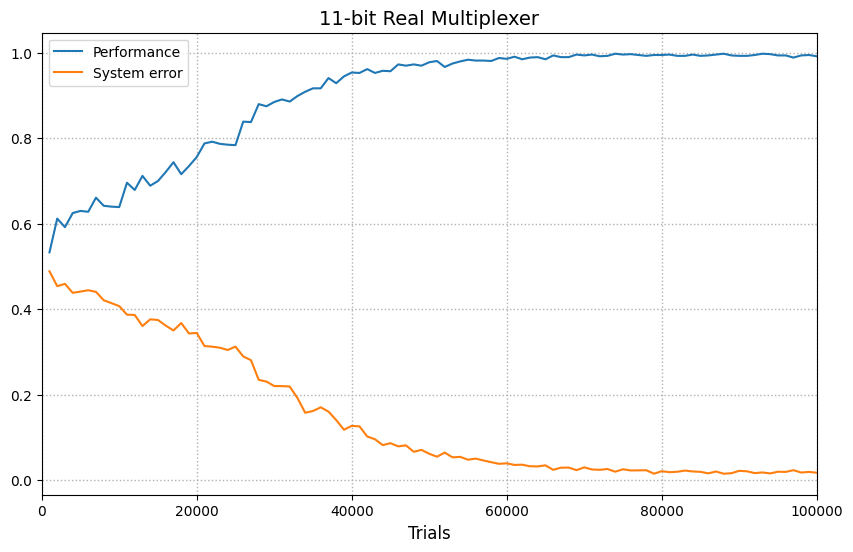

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(trials, performance, label="Performance")
plt.plot(trials, error, label="System error")
plt.grid(linestyle="dotted", linewidth=1)
plt.title(f"{mux.n_bits}-bit Real Multiplexer", fontsize=14)
plt.xlabel("Trials", fontsize=12)
plt.xlim([0, N * PERF_TRIALS])
plt.legend()
plt.show()